# 作业5

https://irsa.ipac.caltech.edu/data/COSMOS/overview.html数据下载

DECaLS 滤光片曲线 http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=browse&gname=CTIO&gname2=DECam&asttype=

HST COSMOS滤光片曲线 http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=browse&gname=HST&gname2=ACS_WFC&asttype=

肉眼比一下 F606W大概和DESI r-band差不多

In [1]:
# 先获取cosmos场的中心坐标，然后去DESI的viewer界面挑一个星系拿坐标，然后去http://hla.stsci.edu/hlaview.html里面下fits
# 存储在"/home/renhaoye/hlsp_candels_hst_acs_cos-tot-sect12_f606w_v1.0_drz.fits"

In [32]:
# survey_in_desi提供代码，因为大图的wcs信息才是完整的
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import units as u
def index_brickname(bricks_file, ra, dec):
    bricks = fits.getdata(bricks_file)
    ra1, ra2 = bricks["ra1"], bricks["ra2"]
    dec1, dec2 = bricks["dec1"], bricks["dec2"]
    coord = SkyCoord(ra=ra, dec=dec, unit=u.deg)
    ra_deg = coord.ra.deg
    dec_deg = coord.dec.deg
    mask = (ra_deg >= ra1) & (ra_deg <= ra2) & (dec_deg >= dec1) & (dec_deg <= dec2)
    matched_bricks = bricks[mask]
    if len(matched_bricks) > 0:
        return matched_bricks['brickname']
    else:
        return None
index_brickname("/datapool/DESI_LIS/dr10/south/survey-bricks-dr10-south.fits.gz", 150.1919569, 2.2478653)

chararray(['1501p022'], dtype='<U8')

HST ACS F606W pixel scale = 0.03 arcsec/pixel

DESI DECaLS r pixel scale = 0.262 arcsec/pixel

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


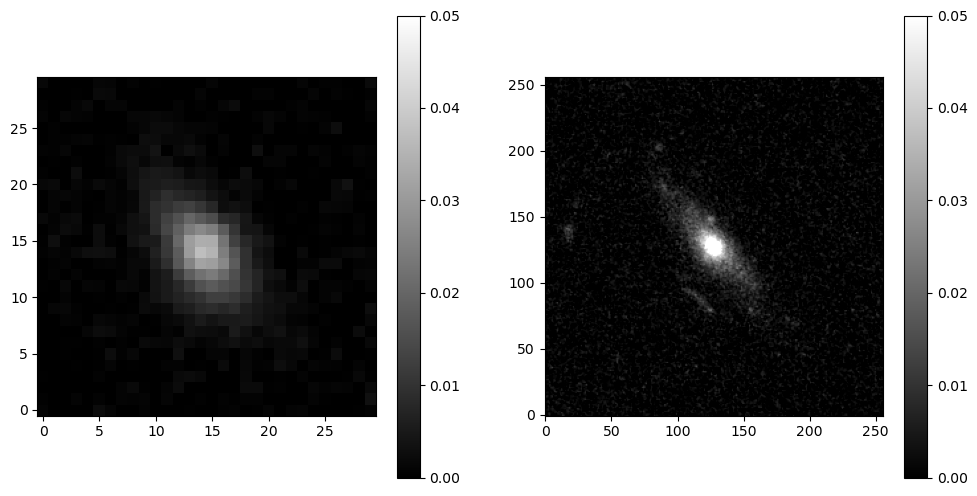

In [26]:
desi_img_path = "/datapool/DESI_LIS/dr10/south/coadd/150/1501p022/legacysurvey-1501p022-image-r.fits.fz"
hst_img_path = "/home/renhaoye/hlsp_candels_hst_acs_cos-tot-sect12_f606w_v1.0_drz.fits"
# 都显示给定ra=150.1919569, dec=2.2478653处的256*256的pixel大小的图像
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.io import fits
with fits.open(desi_img_path) as desi_hdul:
    desi_wcs = WCS(desi_hdul[1].header)
    desi_data = desi_hdul[1].data
    desi_coord = SkyCoord(ra=150.1919569, dec=2.2478653, unit=u.deg)
    desi_cutout = Cutout2D(desi_data, desi_coord, (30, 30), wcs=desi_wcs) # 换到差不多的pixel scale
    desi_cutout_data = desi_cutout.data
    desi_cutout_wcs = desi_cutout.wcs
    desi_cutout_header = desi_cutout_wcs.to_header()
    desi_cutout_header.update(desi_hdul[1].header)
with fits.open(hst_img_path) as hst_hdul:
    hst_wcs = WCS(hst_hdul[0].header)
    hst_data = hst_hdul[0].data
    hst_wcs.sip = None
    hst_coord = SkyCoord(ra=150.1919569, dec=2.2478653, unit=u.deg)
    hst_cutout = Cutout2D(hst_data, hst_coord, (256, 256), wcs=hst_wcs)
    hst_cutout_data = hst_cutout.data
    hst_cutout_wcs = hst_cutout.wcs
    hst_cutout_header = hst_cutout_wcs.to_header()
    hst_cutout_header.update(hst_hdul[0].header)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(desi_cutout_data, origin='lower', cmap='gray', vmin=0., vmax=0.05)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(hst_cutout_data, origin='lower', cmap='gray', vmin=0., vmax=0.05)
plt.colorbar()
plt.show()

good

两个图单位不太一样，我没转换，DESI是Nanomaggy，HST是ELECTRONS

In [31]:
# 找出两个图流量最高的像素坐标及其ra, dec
import numpy as np
desi_max = np.max(desi_cutout_data)
hst_max = np.max(hst_cutout_data)
desi_max_idx = np.where(desi_cutout_data == desi_max)
hst_max_idx = np.where(hst_cutout_data == hst_max)
print(desi_max_idx, hst_max_idx)
desi_cutout_wcs.pixel_to_world(desi_max_idx[1], desi_max_idx[0]), hst_cutout_wcs.pixel_to_world(hst_max_idx[1], hst_max_idx[0])

(array([14]), array([14])) (array([127]), array([127]))


(<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
     [(150.19197067, 2.24785152)]>,
 <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
     [(150.19196694, 2.24785863)]>)

# 作业6

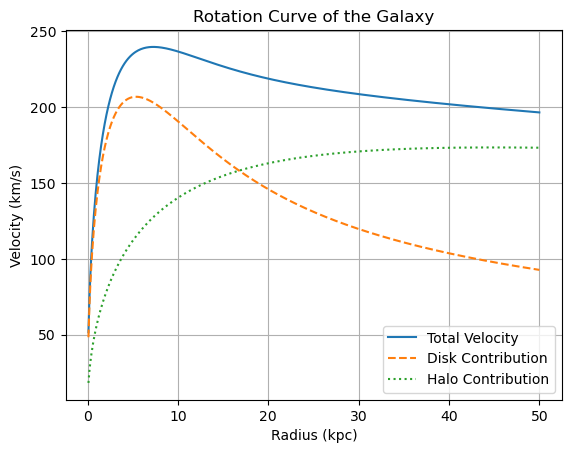

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.constants import G
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo

M_d = 1e11 * u.Msun       # 星盘质量
M_halo = 1e12 * u.Msun    # 暗物质晕质量
R_d = 3 * u.kpc           # 星盘标度长度
c = 10                    # 浓度参数
H0 = cosmo.H(0)
rho_crit = cosmo.critical_density(0) # 临界密度
r200 = ((3 * M_halo) / (4 * np.pi * 200 * rho_crit))**(1/3)
r_s = r200 / c
delta_c = (200 / 3) * c**3 / (np.log(1 + c) - c / (1 + c))

# 计算 rho_0
rho_0 = delta_c * rho_crit  # 单位为 Msun/kpc^3
r = np.linspace(0.1, 50, 500) * u.kpc

# 计算指数盘的表面密度 Σ_0
Sigma_0 = M_d / (2 * np.pi * R_d**2)  # 单位为 Msun/kpc^2

def v_disk(r):
    v_disk_squared = (G * M_d / r) * (1 - np.exp(-r / R_d) * (1 + r / R_d))
    v_disk_squared = v_disk_squared.to(u.km**2 / u.s**2)
    v_disk_value = np.sqrt(v_disk_squared)
    return v_disk_value

def v_halo(r):
    x = r / r_s
    M_r = 4 * np.pi * rho_0 * r_s**3 * (np.log(1 + x) - x / (1 + x))
    v_halo_squared = (G * M_r / r).to(u.km**2 / u.s**2)
    v_halo_value = np.sqrt(v_halo_squared)
    return v_halo_value

v_d = v_disk(r)
v_h = v_halo(r)
v_total = np.sqrt(v_d**2 + v_h**2)

plt.plot(r.value, v_total.value, label='Total Velocity')
plt.plot(r.value, v_disk(r).value, label='Disk Contribution', linestyle='--')
plt.plot(r.value, v_halo(r).value, label='Halo Contribution', linestyle=':')
plt.xlabel('Radius (kpc)')
plt.ylabel('Velocity (km/s)')
plt.title('Rotation Curve of the Galaxy')
plt.legend()
plt.grid(True)
plt.show()


# good，盘星系的旋转曲线不能完全由3维的开普勒运动公式计算

# 作业7

In [83]:
import numpy as np
from scipy.integrate import quad
def sersic_profile(r, n, I0, alpha):
    return I0 * np.exp(-(r / alpha)**(1/n))

def total_flux(n, I0, alpha):
    integral, _ = quad(lambda r: 2 * np.pi * r * sersic_profile(r, n, I0, alpha), 0, np.inf)
    return integral

def radius_ratio(n, I0, alpha):
    R50 = quad(lambda r: 2 * np.pi * r * sersic_profile(r, n, I0, alpha), 0, alpha/2)[0]
    R90 = quad(lambda r: 2 * np.pi * r * sersic_profile(r, n, I0, alpha), 0, alpha * 0.9)[0]
    return R90 / R50

n_values = [1, 3, 4]
I0 = 1  # 假设为1
alpha = 1  # 假设为1

for n in n_values:
    ratio = radius_ratio(n, I0, alpha)
    print(f"Sérsic指数n={n}时，R90/R50={ratio}")


Sérsic指数n=1时，R90/R50=2.5222564429856655
Sérsic指数n=3时，R90/R50=2.803330177641098
Sérsic指数n=4时，R90/R50=2.8821287528595136


#没算对，积分积到哪里？
